# PIP


In [1]:
%pip install faker
%pip install easynmt #install package



Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#install': Expected package name at the start of dependency specifier
    #install
    ^


# Data Cleaning


## Load Dataset


In [21]:
# prompt: load dataset and drop the flags column

import pandas as pd

# Load the dataset (replace 'your_dataset.csv' with the actual file name)
# Load the dataset from a JSON file
data = pd.read_json('generated_fake_data.json')

# Drop the 'flags' column
data = data.drop('flags', axis=1)

# Now you can work with the dataset without the 'flags' column
print(data.head())


                                         instruction category        intent  \
0        question about cancelling order ORD-5090958    ORDER  cancel_order   
1  i have a question about cancelling oorder ORD-...    ORDER  cancel_order   
2         i need help cancelling puchase ORD-5914872    ORDER  cancel_order   
3              I need to cancel purchase ORD-3943164    ORDER  cancel_order   
4  I cannot afford this order, cancel purchase OR...    ORDER  cancel_order   

                                            response  has_placeholder  \
0  I've understood you have a question regarding ...             True   
1  I've been informed that you have a question ab...             True   
2  I can sense that you're seeking assistance wit...             True   
3  I understood that you need assistance with can...             True   
4  I'm sensitive to the fact that you're facing f...             True   

                                     ner_labels_only  
0  [{'text': 'ORD-5090958', 'la

## Lowercase


In [22]:

# Debug: Check for existing NaN values
print("Before lowercase conversion:")
print(data.isnull().sum())

# Convert all object type columns to lowercase while preserving NaN values
for column in data.select_dtypes(include=['object']).columns:
    data[column] = data[column].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Debug: Check for NaN values after conversion
print("After lowercase conversion:")
print(data.isnull().sum())

# Print the DataFrame
print(data.head())


Before lowercase conversion:
instruction        0
category           0
intent             0
response           0
has_placeholder    0
ner_labels_only    0
dtype: int64
After lowercase conversion:
instruction        0
category           0
intent             0
response           0
has_placeholder    0
ner_labels_only    0
dtype: int64
                                         instruction category        intent  \
0        question about cancelling order ord-5090958    order  cancel_order   
1  i have a question about cancelling oorder ord-...    order  cancel_order   
2         i need help cancelling puchase ord-5914872    order  cancel_order   
3              i need to cancel purchase ord-3943164    order  cancel_order   
4  i cannot afford this order, cancel purchase or...    order  cancel_order   

                                            response  has_placeholder  \
0  i've understood you have a question regarding ...             True   
1  i've been informed that you have a questi

# Check missing values


In [25]:
# prompt: check missing values

print(data.isnull().sum())


instruction        0
category           0
intent             0
response           0
has_placeholder    0
ner_labels_only    0
dtype: int64


## Drop missing values


In [26]:
# prompt: drop missing values in the instruction_augmented column

data = data.dropna(subset=['instruction'])
print(data.isnull().sum())


instruction        0
category           0
intent             0
response           0
has_placeholder    0
ner_labels_only    0
dtype: int64


# Check Distribution


## Category, Intent, NER


Intent Distribution:
 intent
edit_account                0.037213
switch_account              0.037213
check_invoice               0.037213
complaint                   0.037213
contact_customer_service    0.037213
delivery_period             0.037176
registration_problems       0.037176
check_payment_methods       0.037176
contact_human_agent         0.037176
payment_issue               0.037176
newsletter_subscription     0.037176
get_invoice                 0.037176
place_order                 0.037139
cancel_order                0.037139
track_refund                0.037139
change_order                0.037102
get_refund                  0.037102
create_account              0.037102
check_refund_policy         0.037102
review                      0.037102
set_up_shipping_address     0.037102
delivery_options            0.037027
delete_account              0.037027
recover_password            0.037027
track_order                 0.037027
change_shipping_address     0.036209
check_can

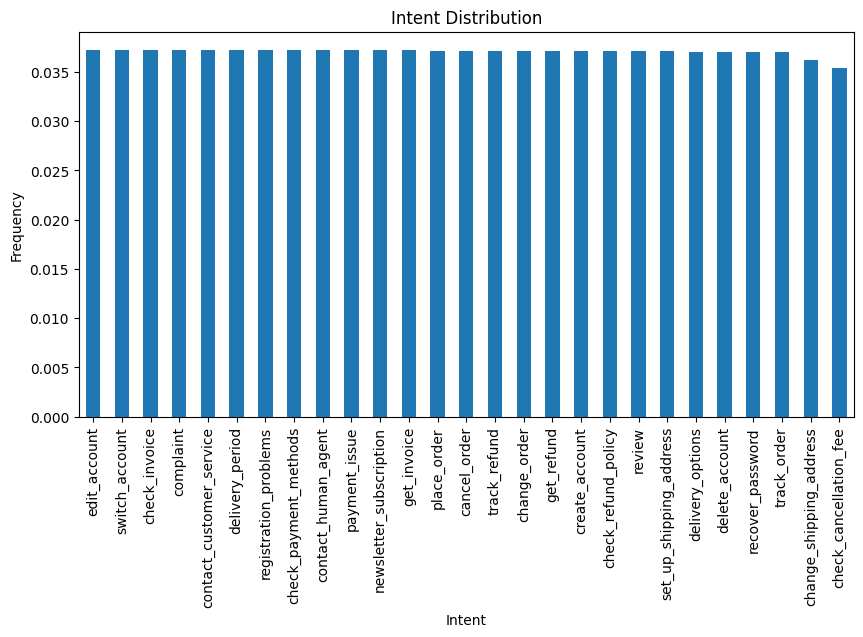

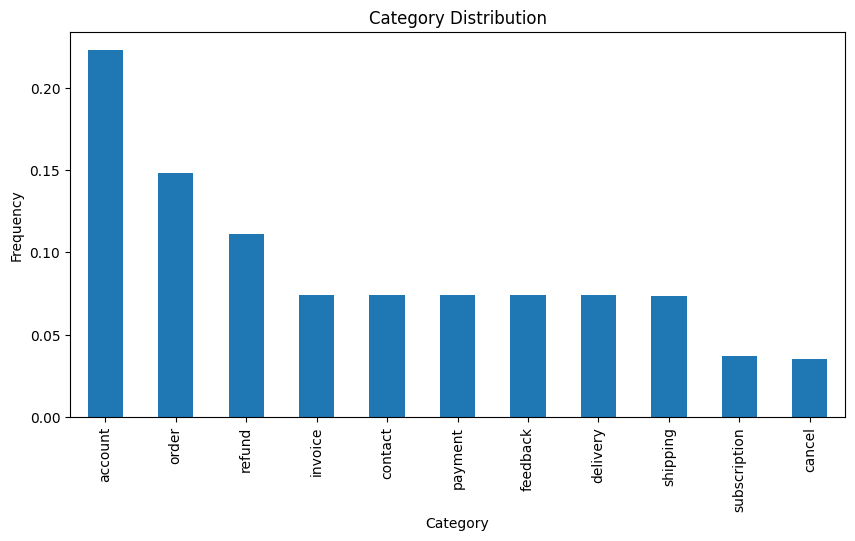


NER Label Counts:
Counter({'order_number': 2907, 'account_type': 1011, 'person_name': 887, 'account_category': 822, 'refund_amount': 624, 'currency_symbol': 372, 'delivery_city': 234, 'delivery_country': 176, 'invoice_number': 8})


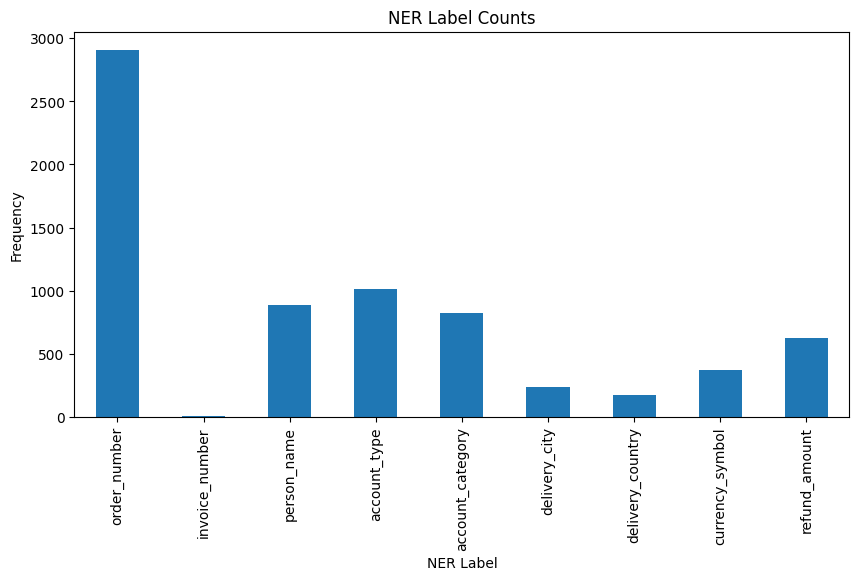

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


# Check Distribution for 'intent' and 'category' columns
print("Intent Distribution:\n", data['intent'].value_counts(normalize=True))
print("\nCategory Distribution:\n", data['category'].value_counts(normalize=True))

# Plot Intent Distribution
plt.figure(figsize=(10, 5))
data['intent'].value_counts(normalize=True).plot(kind='bar')
plt.title('Intent Distribution')
plt.xlabel('Intent')
plt.ylabel('Frequency')
plt.show()

# Plot Category Distribution
plt.figure(figsize=(10, 5))
data['category'].value_counts(normalize=True).plot(kind='bar')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

# Extract NER labels from the 'ner_labels_only' column
ner_labels = [label['label'] for sublist in data['ner_labels_only'] if isinstance(sublist, list) for label in sublist if isinstance(label, dict)]
ner_label_counts = Counter(ner_labels)
print("\nNER Label Counts:")
print(ner_label_counts)

# Plot NER Label Counts
if ner_label_counts:
    plt.figure(figsize=(10, 5))
    pd.Series(ner_label_counts).plot(kind='bar')
    plt.title('NER Label Counts')
    plt.xlabel('NER Label')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("No NER labels found to plot.")


## Augmentation Distribution (for augmented dataset only)


In [ ]:
# prompt: check aug distribution based on the  augmentation_technique column and total counts of it also include the distribution in each intent

# Check augmentation technique distribution
aug_counts = data['augmentation_technique'].value_counts()
print("\nAugmentation Technique Distribution:\n", aug_counts)
print("\nAugmentation Technique Distribution (normalized):\n", aug_counts / len(data))

# Check augmentation technique distribution per intent
aug_intent_distribution = data.groupby(['intent', 'augmentation_technique']).size().unstack(fill_value=0)
print("\nAugmentation Technique Distribution per Intent:\n", aug_intent_distribution)

# Calculate and display the distribution within each intent
for intent in aug_intent_distribution.index:
    intent_counts = aug_intent_distribution.loc[intent]
    intent_distribution = intent_counts / intent_counts.sum()
    print(f"\nDistribution for intent '{intent}':\n{intent_distribution}")


## Save Data


In [28]:

# Save to CSV
data.to_csv("dataset_after_preprocessed.csv", index=False)

# Save to JSON Lines
data.to_json("dataset_after_preprocessed.json", orient="records", lines=True)
